# Advanced Lane Finding

In this project, I will setup an image processing pipeline including:
1. camera calibration and distortion correction
2. create a combination of methods (color transforms, gradients)
3. perform a perspective transform (transform an image to a birds-eye view)
4. locate the laneline pixels and fit their positions with a polynomial
5. calculate the curvature of the lane and the position of the vehicle 
6. warp back the rectified image to the original image

In [1]:
import numpy as np
import cv2
import glob
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ROOT_PATH = '/home/downloads/carnd-p4-advanced-lane-lines'
CAMERA_CAL_PATH = Path(ROOT_PATH)/'camera_cal'
TEST_IMG_PATH = Path(ROOT_PATH)/'test_images'

## Camera Calibration and Distortion Correction

In [3]:
def calibrate_camera(img_path, nx=6, ny=9):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    img_size = None
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)

    # arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for fname in img_path.glob('calibration*.jpg'):
        img = cv2.imread(fname.as_posix())
        if img_size is None:
            img_size = (img.shape[1], img.shape[0])
            print('img_size', img_size)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (ny, nx), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    # calibrate 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist

In [4]:
mtx, dist = calibrate_camera(CAMERA_CAL_PATH, nx=6, ny=9)

img_size (1280, 720)


In [5]:
def plot_undist(img_path, mtx, dist):
    img = cv2.imread(img_path)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('calibration_wide/test_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    # dist_pickle = {}
    # dist_pickle["mtx"] = mtx
    # dist_pickle["dist"] = dist
    # pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1.imshow(img_rgb)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()

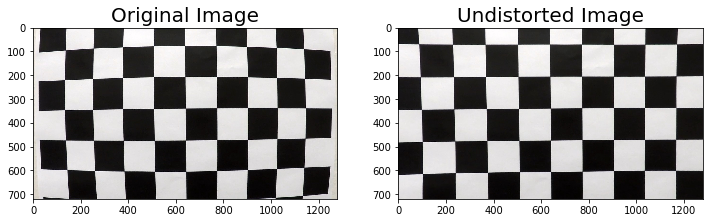

In [6]:
plot_undist((CAMERA_CAL_PATH/'calibration1.jpg').as_posix(), mtx, dist)

Applying undistortion on all test images

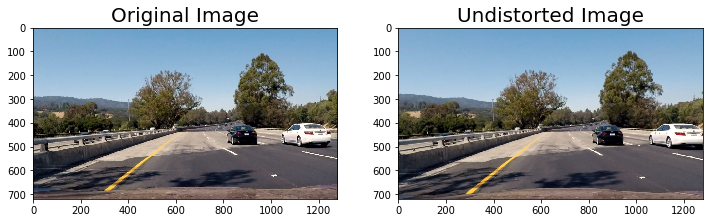

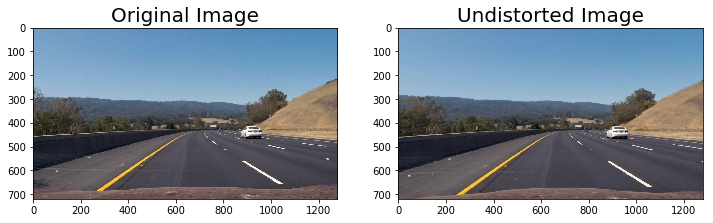

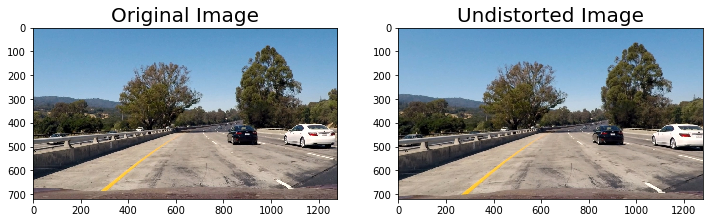

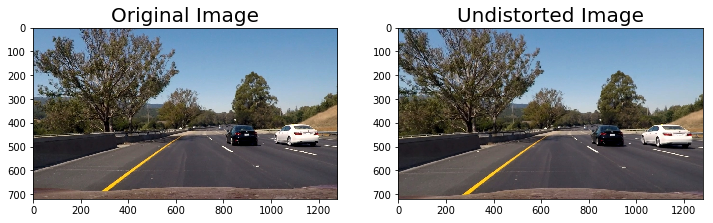

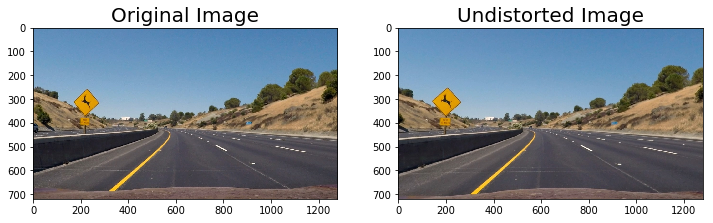

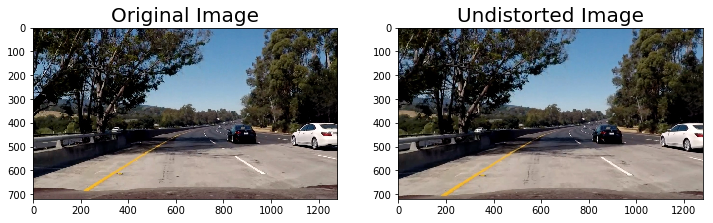

In [7]:
for img_path in TEST_IMG_PATH.glob('test*.jpg'):
    plot_undist(img_path.as_posix(), mtx, dist)

## Image Gradients and Color

### Image Gradients

Take one test image for a quick check

In [69]:
#test_image_path = list(TEST_IMG_PATH.glob('*.jpg'))[0].as_posix()
test_image_path = '/home/downloads/carnd-p4-advanced-lane-lines/test_images/test4.jpg'
test_image_rgb = plt.imread(test_image_path)

In [164]:
def plot_test_image(img_rgb, img_bin, image_names=['Original Image', 'Thresholded Gradient']):
    # Plot the result 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
    f.tight_layout() 
    ax1.imshow(img_rgb) 
    ax1.set_title(image_names[0], fontsize=30) 
    ax2.imshow(img_bin, cmap='gray') 
    ax2.set_title(image_names[1], fontsize=30) 
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
    plt.show()

Sobel operator

In [233]:
def abs_sobel_thresh(img_path, orient='x', sobel_kernel=3, thresh=(20, 100)):
    thresh_min, thresh_max = thresh
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

    if orient == 'x': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    elif orient == 'y': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) 

    abs_sobel = np.absolute(sobel) 
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel)) 
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 
    return binary_output

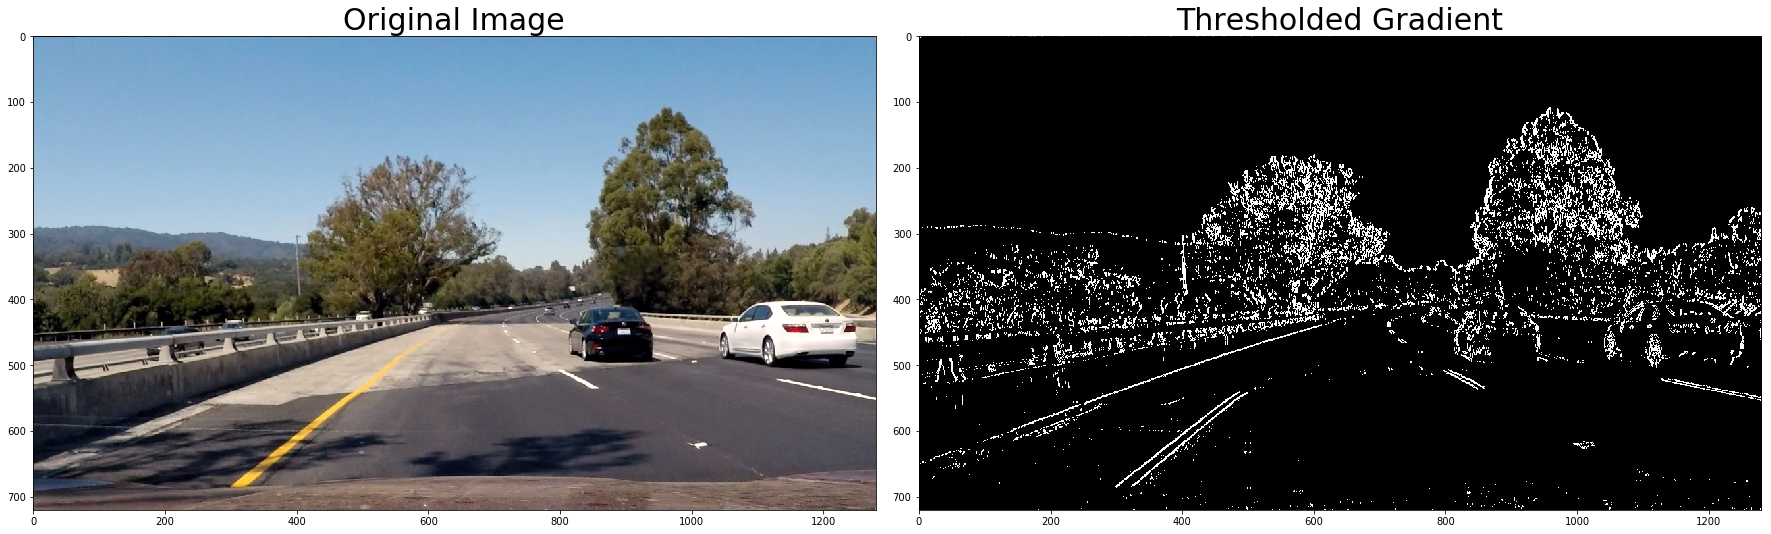

In [234]:
grad_binary = abs_sobel_thresh(test_image_path, orient='x', thresh=(20, 100))
plot_test_image(test_image_rgb, grad_binary)

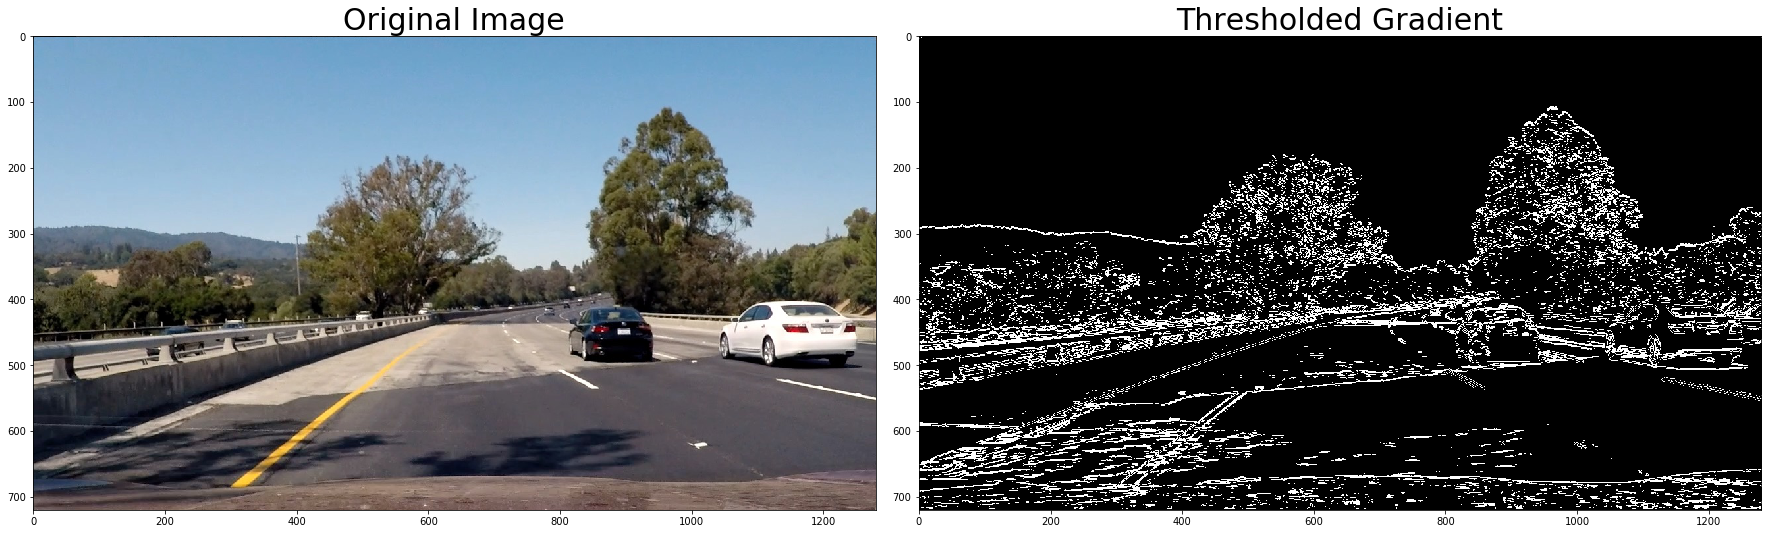

In [235]:
grad_binary = abs_sobel_thresh(test_image_path, orient='y', thresh=(20, 80))
plot_test_image(test_image_rgb, grad_binary)

Gradient magnitude

In [231]:
def mag_thresh(img_path, sobel_kernel=3, mag_thresh=(20, 100)): 
    thresh_min, thresh_max = mag_thresh
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) 
    gradmag = np.sqrt(sobelx**2 + sobely**2) 
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag)).astype(np.uint8) 
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1 

    return binary_output 

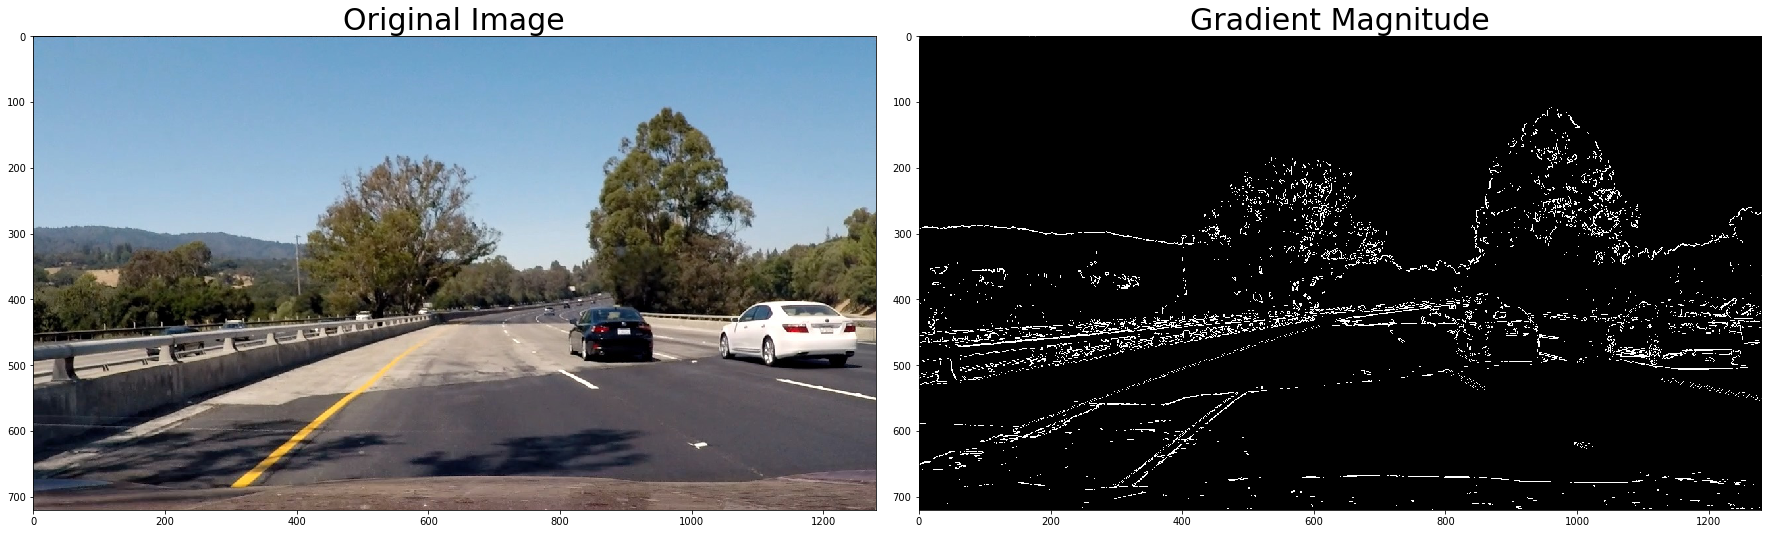

In [245]:
mag_binary = mag_thresh(test_image_path, sobel_kernel=5, mag_thresh=(50, 90))
plot_test_image(test_image_rgb, mag_binary, image_names=['Original Image', 'Gradient Magnitude'])

Gradient Threshold

In [225]:
def dir_threshold(img_path, sobel_kernel=3, thresh=(0, np.pi/2)):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

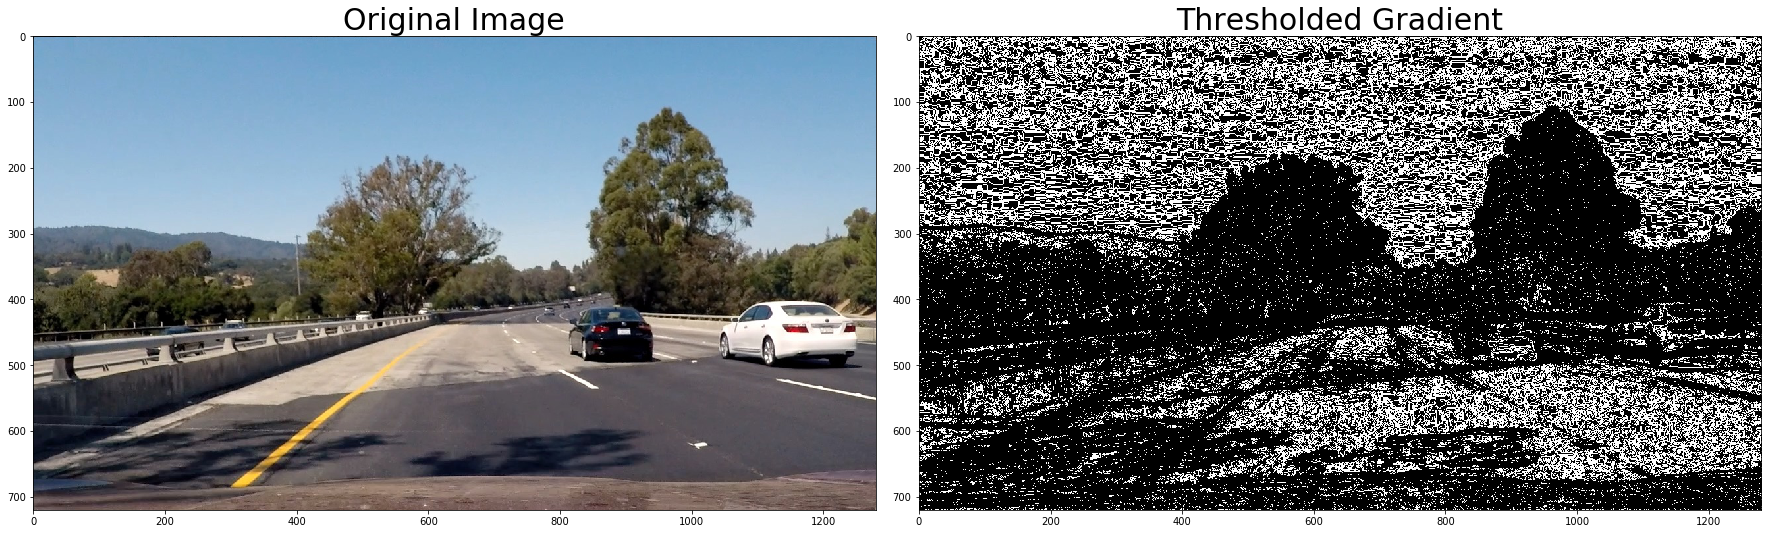

In [251]:
dir_binary = mag_thresh(test_image_path, sobel_kernel=15, mag_thresh=(0.5, 2))
plot_test_image(test_image_rgb, dir_binary)

### Image Color

First compare RGB and HLS channels

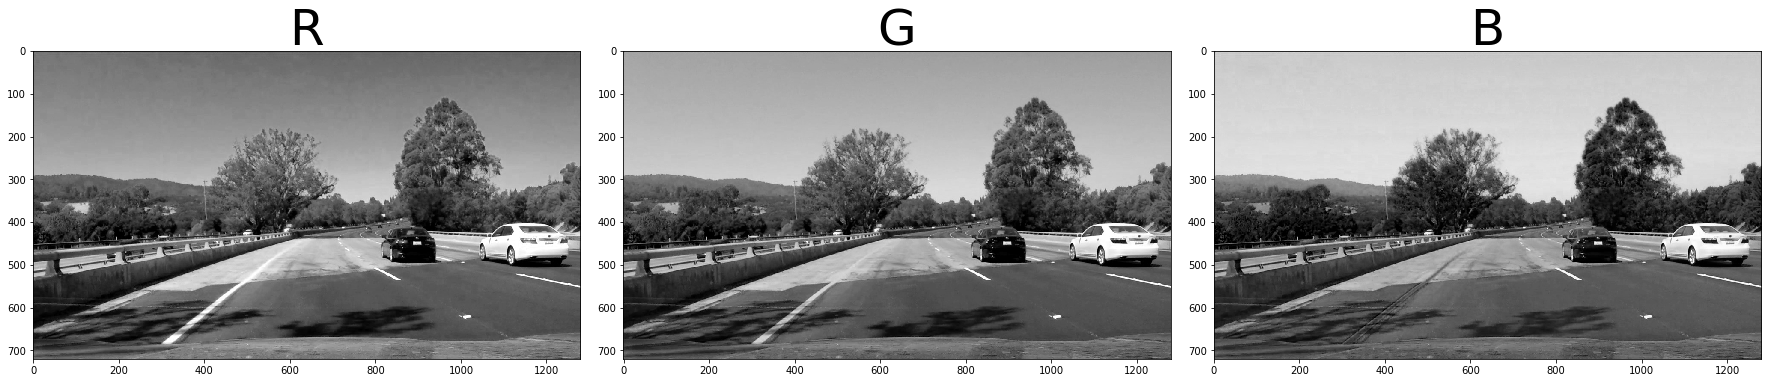

In [79]:
R = test_image_rgb[:, :, 0]
G = test_image_rgb[:, :, 1]
B = test_image_rgb[:, :, 2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9)) 
f.tight_layout() 
ax1.imshow(R, cmap='gray') 
ax1.set_title('R', fontsize=50) 
ax2.imshow(G, cmap='gray') 
ax2.set_title('G', fontsize=50) 
ax3.imshow(B, cmap='gray') 
ax3.set_title('B', fontsize=50) 
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

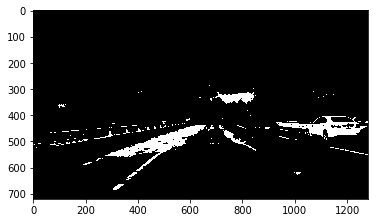

In [121]:
thresh = (200, 255)
r_bin = np.zeros_like(S)
r_bin[(R>thresh[0])&(R<=thresh[1])] = 1
plt.imshow(r_bin, cmap='gray')

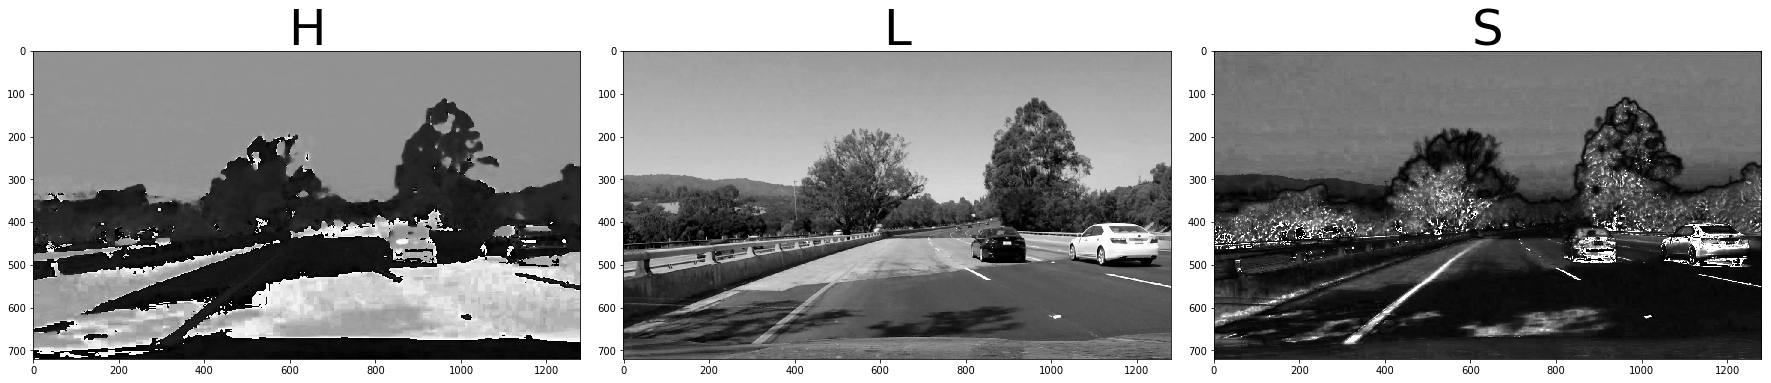

In [84]:
test_image_hls = cv2.cvtColor(test_image_rgb, cv2.COLOR_RGB2HLS)
H = test_image_hls[:, :, 0]
L = test_image_hls[:, :, 1]
S = test_image_hls[:, :, 2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9)) 
f.tight_layout() 
ax1.imshow(H, cmap='gray') 
ax1.set_title('H', fontsize=50) 
ax2.imshow(L, cmap='gray') 
ax2.set_title('L', fontsize=50) 
ax3.imshow(S, cmap='gray') 
ax3.set_title('S', fontsize=50) 
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

Seems S channel gives better result. Let's try add some thresholds:

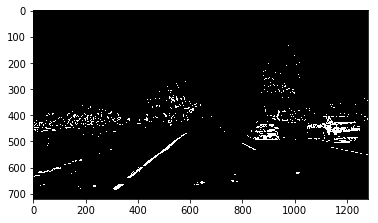

In [255]:
thresh = (170, 255)
s_bin = np.zeros_like(S)
s_bin[(S>thresh[0])&(S<=thresh[1])] = 1
plt.imshow(s_bin, cmap='gray')

### Combining Gradient and Color

In [211]:
def select_image(img_path, sx_thresh=(20, 100), s_thresh=(170, 255)):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

    # Convert to HLS color space and separate the V channel 
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
    l_channel = hls[:,:,1] 
    s_channel = hls[:,:,2] 
    # Sobel x 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x 
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 

    # Threshold x gradient 
    sxbinary = np.zeros_like(scaled_sobel) 
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1 

    # Threshold color channel 
    s_binary = np.zeros_like(s_channel) 
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1 
    # Stack each channel 
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255 
    #color_binary_rgb = cv2.cvtColor(color_binary, cv2.COLOR_HLS2RGB)
    return color_binary

In [212]:
def plot_binary_images(color_bin):
    combined_bin = np.zeros_like(color_bin[:, :, 0])
    combined_bin[(color_bin[:,:,1]/255==1)|(color_bin[:,:,2]/255==1)] = 1

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
    f.tight_layout() 
    ax1.imshow(color_bin) 
    ax1.set_title('Stacked thresholds', fontsize=30) 
    ax2.imshow(combined_bin, cmap='gray') 
    ax2.set_title('Combined S channel and gradient thresholds', fontsize=30) 
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
    plt.show()

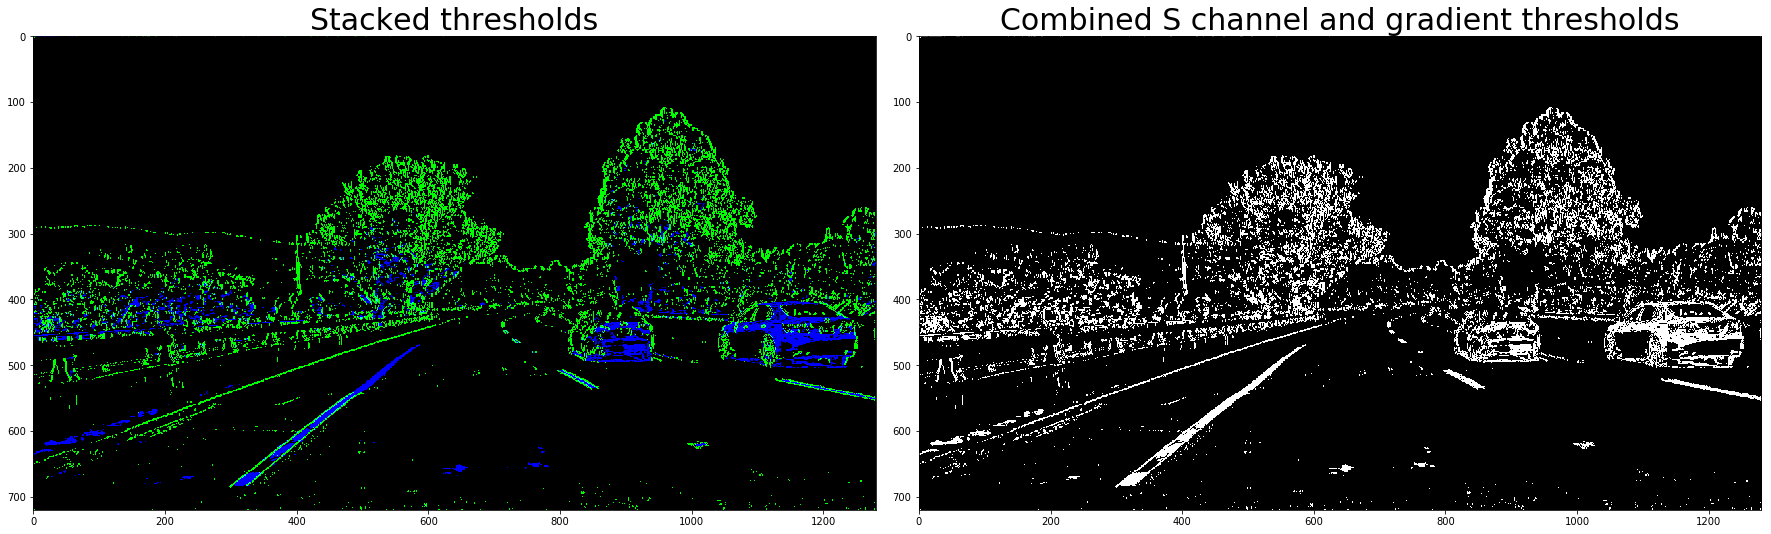

In [213]:
color_bin = select_image(test_image_path)
plot_binary_images(color_bin)

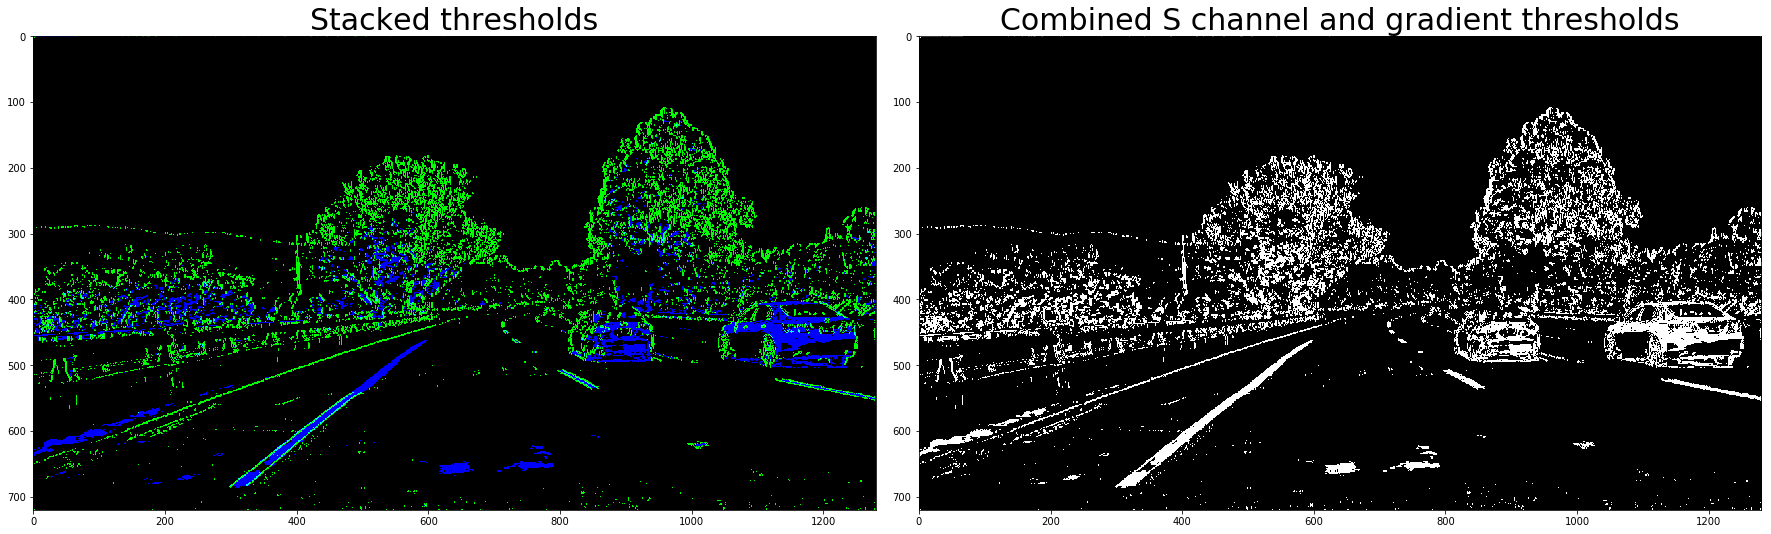

In [254]:
color_bin = select_image(test_image_path, s_thresh=(140, 255))
plot_binary_images(color_bin)